### DefectNet: Universal defect predictor

Test on how it extrapolated on unknown crystals

Let's start from loading our data and preprocess it.

In [7]:
import pandas as pd
raw_data = pd.read_pickle('DefectNet_data_v0.1.pkl')
raw_data = raw_data.sort_values(by='formula_j0')
raw_data.head(10)

,formula_j0,formula_j,eigvals_j0,eigvals_j,dopant_options_j0
8134,Ag100N100O300,Ag97BaCl3F3GaInN99O292,"[0.01634691114418068j, 0.016346634570978742j, ...","[0.00180435847701693j, 0.000646769140085577j, ...","{B, La, Sc, Ga, F, C, Ge, In, Ba, Cl}"
8135,Ag100N100O300,CAg98F2GeInN97O297,"[0.01634691114418068j, 0.016346634570978742j, ...","[3.105556153111761e-05j, 2.8843859773039335e-0...","{B, La, Sc, Ga, F, C, Ge, In, Ba, Cl}"
563,Ag100N100O300,Ag100F2N100O297,"[0.01634691114418068j, 0.016346634570978742j, ...","[3.7891799767330467e-05j, 2.999148477703166e-0...","{B, La, Sc, Ga, F, C, Ge, In, Ba, Cl}"
6807,Ag100Nb100O300,Ag94Cl5FInNaNb97O292,"[0.02194834122464369j, 0.021948174686736165j, ...","[0.0014049543231868526j, 0.0009997825936025496...","{W, O, Ga, Ti, Ca, F, Rb, In, Cl, Na}"
6810,Ag100Nb100O300,Ag100CaCl2FNb99O294,"[0.02194834122464369j, 0.021948174686736165j, ...","[0.0025251451504176873j, 4.1871220574188796e-0...","{W, O, Ga, Ti, Ca, F, Rb, In, Cl, Na}"
6809,Ag100Nb100O300,Ag97CaClF3Nb96O289Rb,"[0.02194834122464369j, 0.021948174686736165j, ...","[0.002601842318750908j, 2.8592880334564693e-05...","{W, O, Ga, Ti, Ca, F, Rb, In, Cl, Na}"
6808,Ag100Nb100O300,Ag97CaCl3FNb98O292,"[0.02194834122464369j, 0.021948174686736165j, ...","[0.008379229773162517j, 0.0037407363557626894j...","{W, O, Ga, Ti, Ca, F, Rb, In, Cl, Na}"
6806,Ag100Nb100O300,Ag93FGaInNb100O293,"[0.02194834122464369j, 0.021948174686736165j, ...","[0.002441877783863843j, 0.0011182641787109155j...","{W, O, Ga, Ti, Ca, F, Rb, In, Cl, Na}"
7563,Ag108As108S216,Ag101As107Ba2Cl3GaMg2RbS211,"[1.4380611968990048e-05j, 8.14173110002702e-06...","[0.001599435812596407j, 1.5353016879668927e-05...","{Mg, Cs, Ga, Tl, Li, Rb, In, Ba, Cl, Na}"
7565,Ag108As108S216,Ag101As106Cl3InMgRbS210,"[1.4380611968990048e-05j, 8.14173110002702e-06...","[0.0025765014369328525j, 0.0010194965930882195...","{Mg, Cs, Ga, Tl, Li, Rb, In, Ba, Cl, Na}"


Now we encode these elements into processed `torch.Tensor` and build a dataset.

In [8]:
import re
import numpy as np
import torch
from tqdm import tqdm
import torch.nn.functional as F

# Atomic number dictionary
atomic_numbers = {
    'H': 1, 'He': 2, 'Li': 3, 'Be': 4, 'B': 5, 'C': 6, 'N': 7, 'O': 8, 'F': 9, 'Ne': 10,
    'Na': 11, 'Mg': 12, 'Al': 13, 'Si': 14, 'P': 15, 'S': 16, 'Cl': 17, 'Ar': 18,
    'K': 19, 'Ca': 20, 'Sc': 21, 'Ti': 22, 'V': 23, 'Cr': 24, 'Mn': 25, 'Fe': 26,
    'Co': 27, 'Ni': 28, 'Cu': 29, 'Zn': 30, 'Ga': 31, 'Ge': 32, 'As': 33, 'Se': 34,
    'Br': 35, 'Kr': 36, 'Rb': 37, 'Sr': 38, 'Y': 39, 'Zr': 40, 'Nb': 41, 'Mo': 42,
    'Tc': 43, 'Ru': 44, 'Rh': 45, 'Pd': 46, 'Ag': 47, 'Cd': 48, 'In': 49, 'Sn': 50,
    'Sb': 51, 'Te': 52, 'I': 53, 'Xe': 54, 'Cs': 55, 'Ba': 56
}

MAX_LENGTH = 100
VECTOR_LENGTH = len(atomic_numbers) + 1  # 56+1 for vacancy
DOS_FACTOR = 28
DOPE_FACTOR = 10

# Function to parse formula into vector representation
def parse_formula(formula):
    element_counts = {}
    matches = re.findall(r'([A-Z][a-z]*)(\d*)', formula)
    for element, count in matches:
        count = int(count) if count else 1
        element_counts[element] = element_counts.get(element, 0) + count

    return element_counts

# Function to convert formula to vector
def formula_to_vector(formula_counts):
    vector = np.zeros(VECTOR_LENGTH, dtype=np.float64)
    total_atoms = sum(formula_counts.values())

    for element, count in formula_counts.items():
        if element in atomic_numbers:
            vector[atomic_numbers[element]] = count / total_atoms

    return vector, total_atoms

# Function to process dataset
def process_entry(row):
    # Process formula_j0
    formula_j0_counts = parse_formula(row["formula_j0"])
    formula_j0_vector, total_atoms_j0 = formula_to_vector(formula_j0_counts)

    # Process formula_j
    formula_j_counts = parse_formula(row["formula_j"])
    formula_j_vector, total_atoms_j = formula_to_vector(formula_j_counts)

    # Compute elemental difference and vacancy ratio
    diff_vector = np.zeros(VECTOR_LENGTH, dtype=np.float64)
    for element, count in formula_j_counts.items():
        if element in atomic_numbers and element not in formula_j0_counts:
            diff_vector[atomic_numbers[element]] = count / total_atoms_j0

    vacancy_count = total_atoms_j0 - total_atoms_j
    diff_vector[0] = vacancy_count / total_atoms_j0
    diff_vector = diff_vector * DOPE_FACTOR

    # Process eigvals_j0 and eigvals_j
    dos_j0, _ = np.histogram(np.real(row["eigvals_j0"]), bins=100, density=True)
    dos_j, _ = np.histogram(np.real(row["eigvals_j"]), bins=100, density=True)
    dos_j0 = torch.tensor(dos_j0, dtype=torch.float64) / DOS_FACTOR
    dos_j = torch.tensor(np.log10((dos_j + 1e-2) / (dos_j0 + 1e-2)), dtype=torch.float64)

    # Process dopant_options
    dopant_vector = np.zeros(VECTOR_LENGTH, dtype=np.float64)
    dopant_vector[0] = 1 # vacancy always possible
    dopants = row["dopant_options_j0"]
    for dopant in dopants:
        if dopant in atomic_numbers:
            dopant_vector[atomic_numbers[dopant]] = 1

    return dos_j0, dos_j, torch.tensor(dopant_vector), F.pad(torch.tensor(formula_j0_vector, dtype=torch.float32),\
                                               (0, MAX_LENGTH-VECTOR_LENGTH), value=0.0), torch.tensor(diff_vector)


In [9]:
for i in process_entry(raw_data.iloc[0]):
    print(i.shape, end=',')

torch.Size([100]),torch.Size([100]),torch.Size([57]),torch.Size([100]),torch.Size([57]),

/tmp/ipykernel_47024/348403438.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dos_j = torch.tensor(np.log10((dos_j + 1e-2) / (dos_j0 + 1e-2)), dtype=torch.float64)


Perfect, now let's construct dataset.

**Special**: want to test if the model can predict defects for unseen crystals in training set. So for this only, we don't shuffle the order of data.

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from torch.utils.data import Subset

class MaterialsDataset(Dataset):
    def __init__(self, dataframe):
        self.data = [process_entry(row) for _, row in tqdm(dataframe.iterrows(), total=len(dataframe))]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        dos_j0, dos_j, dopant_vector, formula_j0_vector, diff_vector = self.data[idx]

        # Convert to tensors
        dos_j0 = torch.tensor(dos_j0, dtype=torch.float32)  # Original DOS
        dos_j = torch.tensor(dos_j, dtype=torch.float32)  # Modified DOS
        dopant_vector = torch.tensor(dopant_vector, dtype=torch.float32)  # Binary dopant selection
        formula_j0_vector = torch.tensor(formula_j0_vector, dtype=torch.float32)  # Extra stacked channel
        diff_vector = torch.tensor(diff_vector, dtype=torch.float32)  # Output concentration

        return dos_j0, dos_j, dopant_vector, formula_j0_vector, diff_vector

# Create dataset
dataset = MaterialsDataset(raw_data)

# Split dataset (80% Train, 10% Validation, 10% Test)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size  # Ensure full coverage
'''
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])'''

train_indices = list(range(0, train_size))
val_indices = list(range(train_size, train_size + val_size))
test_indices = list(range(train_size + val_size, len(dataset)))

# Create subsets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


  0%|          | 0/13209 [00:00<?, ?it/s]/tmp/ipykernel_47024/348403438.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dos_j = torch.tensor(np.log10((dos_j + 1e-2) / (dos_j0 + 1e-2)), dtype=torch.float64)
100%|██████████| 13209/13209 [00:09<00:00, 1461.88it/s]


DefectNet. Attention is all you need!

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DefectNet(nn.Module):
    def __init__(self, signal_length=100, num_dopants=57, embed_dim=128, num_heads=8, hidden_dim=256):
        super(DefectNet, self).__init__()

        # 1D Convolution to extract features from input curves + formula vector
        self.conv1 = nn.Conv1d(3, 32, kernel_size=5, stride=1, padding=2)  # 3 channels: dos_j0, dos_j, formula_j0
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv1d(64, embed_dim, kernel_size=5, stride=1, padding=2)

        # Embedding layer for dopant options (binary vector)
        self.dopant_embedding = nn.Linear(num_dopants, embed_dim)

        # Self-attention block
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)

        # Fully connected layers for concentration prediction
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, num_dopants)  # Predict concentrations

    def forward(self, dos_j0, dos_j, dopant_options, formula_j0_vector):
        """
        Inputs:
        - dos_j0: (batch, signal_length) - Original DOS
        - dos_j: (batch, signal_length) - Modified DOS
        - dopant_options: (batch, num_dopants) - Binary dopant selection
        - formula_j0_vector: (batch, signal_length) - Extra input channel (zero-padded to 100)

        Returns:
        - Concentration predictions (batch, num_dopants)
        """

        # Stack the input curves together (3 channels)
        x = torch.stack([dos_j0, dos_j, formula_j0_vector], dim=1)  # Shape: (batch, 3, signal_length)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)  # Shape: (batch, embed_dim, signal_length)

        # Convert to sequence for attention (batch, length, embed_dim)
        x = x.permute(0, 2, 1)  

        # Embed dopant options
        dopant_embed = self.dopant_embedding(dopant_options)  # Shape: (batch, embed_dim)

        # Attention mechanism (query is dopant embeddings, key & value are from signal feature maps)
        attn_output, _ = self.attention(dopant_embed.unsqueeze(1), x, x)  # Shape: (batch, 1, embed_dim)

        # Fully connected layers
        out = F.relu(self.fc1(attn_output.squeeze(1)))
        out = F.relu(self.fc2(out))  # Shape: (batch, num_dopants)
        out = self.fc3(out) 
        # Apply mask: zero out concentrations where dopants were not selected
        out = out * dopant_options

        return out  # (batch, num_dopants)

# Initialize model
num_dopants = 57
signal_length = 100
model = DefectNet(signal_length=signal_length, num_dopants=num_dopants)
print(model)

DefectNet(
  (conv1): Conv1d(3, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (dopant_embedding): Linear(in_features=57, out_features=128, bias=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=57, bias=True)
)


Train!

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.MSELoss()

# Training loop
num_epochs = 10

for epoch in tqdm(range(num_epochs)):
    model.train()
    total_loss = 0

    for dos_j0, dos_j, dopant_options, formula_j0_vector, diff_vector in train_loader:
        optimizer.zero_grad()
        pred_concentration = model(dos_j0, dos_j, dopant_options, formula_j0_vector)
        # Compute loss only for active dopants (where dopant_options == 1)
        mask = dopant_options > 0  # Boolean mask
        masked_loss = criterion(pred_concentration[mask], diff_vector[mask])
        masked_loss.backward()
        optimizer.step()
        total_loss += masked_loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for dos_j0, dos_j, dopant_options, formula_j0_vector, diff_vector in val_loader:
            pred_concentration = model(dos_j0, dos_j, dopant_options, formula_j0_vector)
            mask = dopant_options > 0  # Boolean mask
            masked_loss = criterion(pred_concentration[mask], diff_vector[mask])
            val_loss += masked_loss.item()

    avg_val_loss = val_loss / len(val_loader)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_47024/2151526980.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dos_j0 = torch.tensor(dos_j0, dtype=torch.float32)  # Original DOS
/tmp/ipykernel_47024/2151526980.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dos_j = torch.tensor(dos_j, dtype=torch.float32)  # Modified DOS
/tmp/ipykernel_47024/2151526980.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dopant_vector = torch.tensor(dopant_vector, dtype=torch.float32)  # Binary dopant selection
/tmp/ipykernel_47024/215152

Epoch [1/10], Train Loss: 0.001327, Val Loss: 0.001265


 20%|██        | 2/10 [00:06<00:26,  3.35s/it]

Epoch [2/10], Train Loss: 0.001169, Val Loss: 0.001244


 30%|███       | 3/10 [00:10<00:23,  3.34s/it]

Epoch [3/10], Train Loss: 0.001106, Val Loss: 0.001198


 40%|████      | 4/10 [00:13<00:20,  3.34s/it]

Epoch [4/10], Train Loss: 0.001077, Val Loss: 0.001169


 50%|█████     | 5/10 [00:16<00:16,  3.32s/it]

Epoch [5/10], Train Loss: 0.001059, Val Loss: 0.001163


 60%|██████    | 6/10 [00:20<00:13,  3.35s/it]

Epoch [6/10], Train Loss: 0.001053, Val Loss: 0.001186


 70%|███████   | 7/10 [00:23<00:10,  3.50s/it]

Epoch [7/10], Train Loss: 0.001040, Val Loss: 0.001162


 80%|████████  | 8/10 [00:27<00:07,  3.60s/it]

Epoch [8/10], Train Loss: 0.001026, Val Loss: 0.001151


 90%|█████████ | 9/10 [00:31<00:03,  3.66s/it]

Epoch [9/10], Train Loss: 0.001008, Val Loss: 0.001158


100%|██████████| 10/10 [00:35<00:00,  3.53s/it]

Epoch [10/10], Train Loss: 0.001006, Val Loss: 0.001117


Time for testing!

/tmp/ipykernel_47024/2151526980.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dos_j0 = torch.tensor(dos_j0, dtype=torch.float32)  # Original DOS
/tmp/ipykernel_47024/2151526980.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dos_j = torch.tensor(dos_j, dtype=torch.float32)  # Modified DOS
/tmp/ipykernel_47024/2151526980.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dopant_vector = torch.tensor(dopant_vector, dtype=torch.float32)  # Binary dopant selection
/tmp/ipykernel_47024/2151526980.py:20: UserWarning: To copy const

(20, 1, 57)


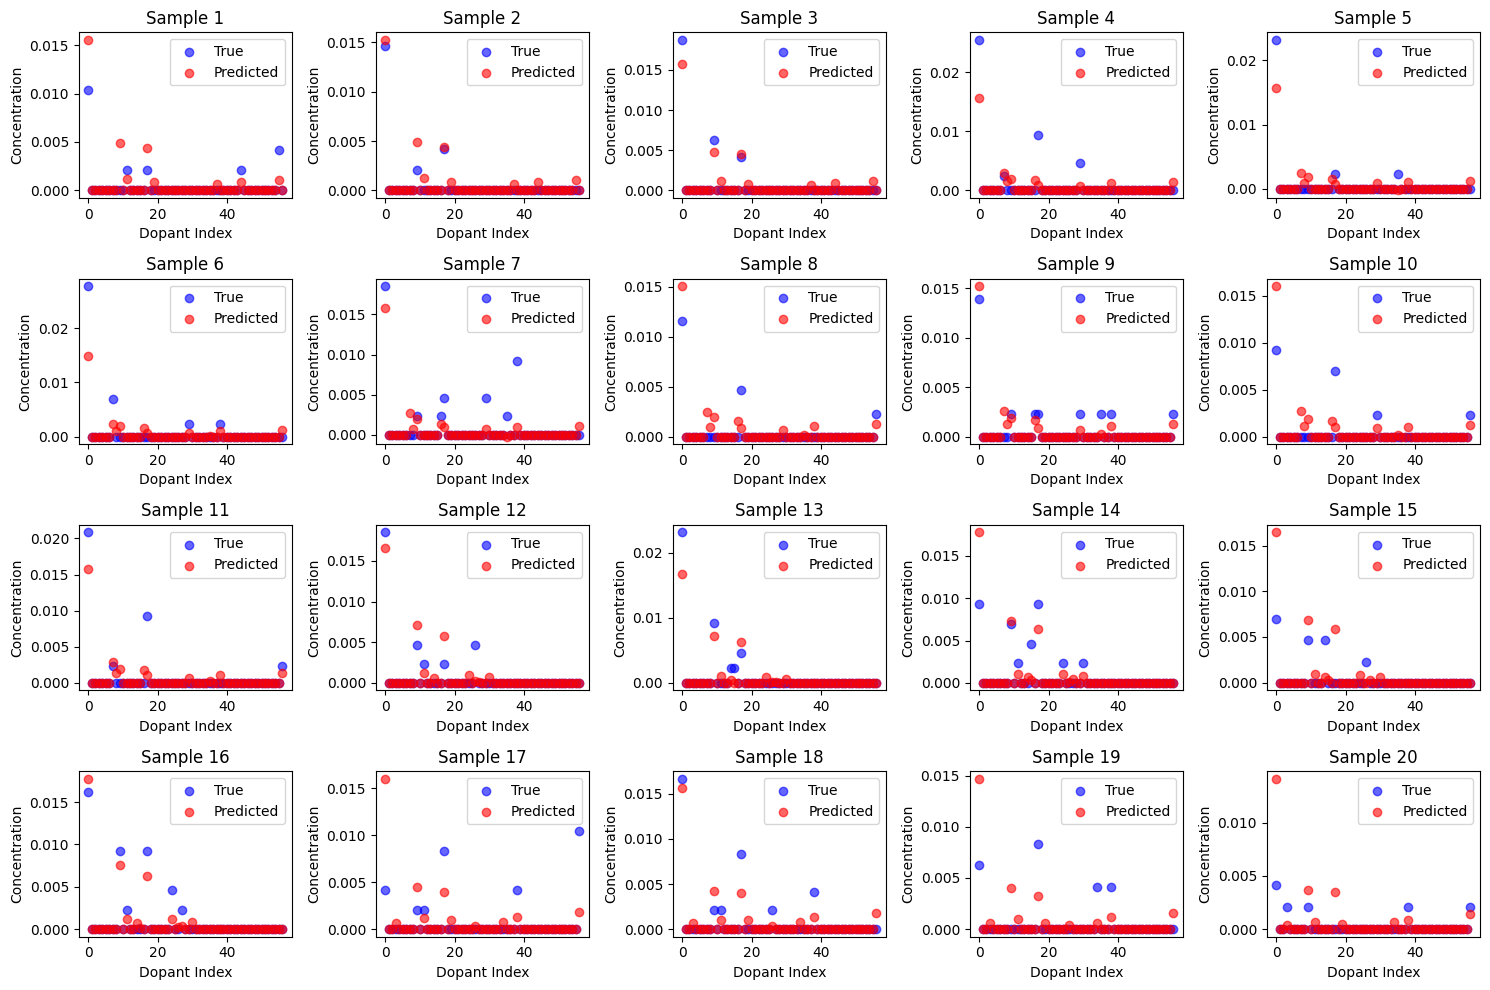

In [13]:
import matplotlib.pyplot as plt
import torch

# Ensure model is in evaluation mode
model.eval()

# Initialize lists for storing predictions and ground truth
true_concentrations = []
pred_concentrations = []

num_samples = 20  # Number of test samples to visualize

with torch.no_grad():  # No need to compute gradients during testing
    for i, (dos_j0, dos_j, dopant_options, formula_j0_vector, diff_vector) in enumerate(test_loader):
        if i >= num_samples:
            break  # Stop after 20 samples

        # Forward pass through the model
        pred_conc = model(dos_j0, dos_j, dopant_options, formula_j0_vector)

        # Store values (convert tensors to numpy for plotting)
        true_concentrations.append(diff_vector.cpu().numpy())
        pred_concentrations.append(pred_conc.cpu().numpy())

# Convert to arrays for easier plotting
true_concentrations = np.array(true_concentrations)
pred_concentrations = np.array(pred_concentrations)
print(true_concentrations.shape)
# Plot predicted vs ground truth concentrations
fig, axes = plt.subplots(4, 5, figsize=(15, 10))  # 4x5 grid for 20 samples
axes = axes.flatten()

for idx in range(num_samples):
    ax = axes[idx]
    ax.scatter(range(57), true_concentrations[idx]/DOPE_FACTOR, label="True", color="blue", alpha=0.6)
    ax.scatter(range(57), pred_concentrations[idx]/DOPE_FACTOR, label="Predicted", color="red", alpha=0.6)
    ax.set_title(f"Sample {idx+1}")
    ax.set_xlabel("Dopant Index")
    ax.set_ylabel("Concentration")
    ax.legend()

plt.tight_layout()
plt.show()


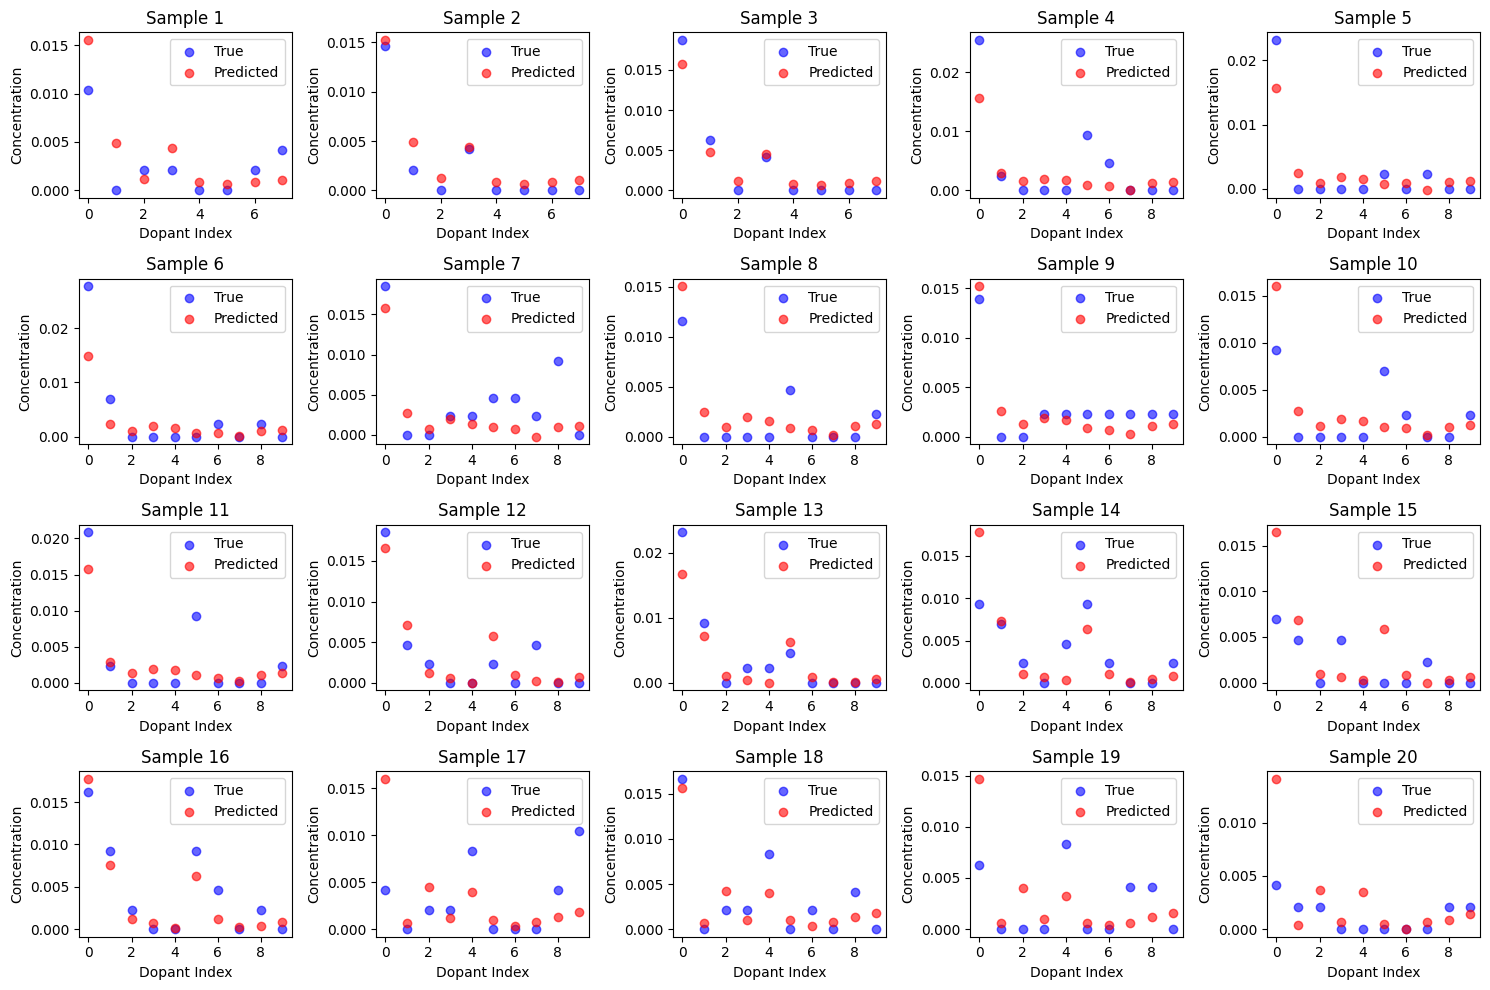

In [14]:
fig, axes = plt.subplots(4, 5, figsize=(15, 10))  # 4x5 grid for 20 samples
axes = axes.flatten()

for idx in range(num_samples):
    ax = axes[idx]

    # Extract nonzero indices where dopants exist
    nonzero_indices = pred_concentrations[idx] != 0  # Mask where true values are nonzero
    #nonzero_pred_indices = pred_concentrations[idx] != 0  # Mask where predicted values are nonzero

    # Filter out zero values
    true_filtered = true_concentrations[idx][nonzero_indices] / DOPE_FACTOR
    pred_filtered = pred_concentrations[idx][nonzero_indices] / DOPE_FACTOR

    # Plot only nonzero values
    ax.scatter(range(len(true_filtered)), true_filtered, label="True", color="blue", alpha=0.6)
    ax.scatter(range(len(true_filtered)), pred_filtered, label="Predicted", color="red", alpha=0.6)

    ax.set_title(f"Sample {idx+1}")
    ax.set_xlabel("Dopant Index")
    ax.set_ylabel("Concentration")
    ax.legend()


plt.tight_layout()
plt.show()


Even works to some extent for this...